这里应该做个嘲讽捏造数据的模型，优化p值使得不应该显著的项而显著。顺便练练pytorch0.4的新api

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm

%matplotlib inline

D:\anaconda\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
import pandas as pd

In [3]:
import torch
import torch.optim as optim

In [104]:
np.random.seed(40)

In [105]:
_X = np.random.random(10)
_Y = np.random.random(10)

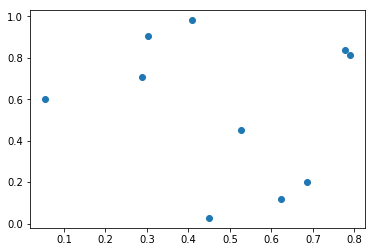

In [106]:
plt.plot(_X,_Y,'o')
plt.show()

In [107]:
df = pd.DataFrame(dict(X=_X,Y=_Y))
smf.ols('Y ~ X',data=df).fit().summary()

D:\anaconda\lib\site-packages\scipy\stats\stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                 -0.103
Method:                 Least Squares   F-statistic:                    0.1631
Date:                Thu, 10 May 2018   Prob (F-statistic):              0.697
Time:                        13:03:41   Log-Likelihood:                -2.9500
No. Observations:                  10   AIC:                             9.900
Df Residuals:                       8   BIC:                             10.51
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6659      0.277      2.407      0.043       0.028       1.304
X             -0.2071      0.513     -0.404      0.697      -1.390       0.975
==============================================================================
Omnibus:                        1.936   Durbin-Watson:                   2.618
Prob(Omnibus):                  0.380   Jarque-Bera (JB):                0.928
Skew:                          -0.323   Prob(JB):                        0.629
Kurtosis:                       1.655   Cond. No.                         5.58
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [108]:
sm_res = smf.ols('Y ~ X',data=df).fit()

In [174]:
sm_res.params

Intercept    0.665852
X           -0.207072
dtype: float64

In [109]:
sm_res.pvalues

Intercept    0.042688
X            0.696937
dtype: float64

In [110]:
X = torch.tensor(_X, dtype=torch.float32)
Y = torch.tensor(_Y, dtype=torch.float32)
a = torch.tensor(0.0, requires_grad=True)
b = torch.tensor(0.0, requires_grad=True)

Yhat = a + b * X
loss = torch.sum((Y-Yhat)**2)

In [111]:
loss

tensor(4.2616)

In [112]:
loss.backward()

In [113]:
a.grad

tensor(-11.2851)

In [114]:
b.grad

tensor(-5.3290)

In [115]:
optimizer = optim.SGD([a,b],lr=0.0001)

In [116]:
for epoch in range(100):
    optimizer.zero_grad()
    Yhat = a + b * X
    loss = torch.sum((Y-Yhat)**2)
    loss.backward()
    #print(loss)
    optimizer.step()

In [117]:
a

tensor(0.1001)

In [118]:
b

tensor(1.00000e-02 *
       4.6815)

In [119]:
loss

tensor(3.0441)

看起来梯度下降ols本身没有偏差，这波把X，Y也纳入优化但这种修改会增加loss

In [120]:
X_origin = torch.tensor(_X, dtype=torch.float32)
X = torch.tensor(_X, requires_grad=True, dtype=torch.float32)
Y_origin = torch.tensor(_Y, dtype=torch.float32)
Y = torch.tensor(_Y, requires_grad=True, dtype=torch.float32)

a = torch.tensor(0.0, requires_grad=True)
b = torch.tensor(0.0, requires_grad=True)

In [121]:
optimizer = optim.SGD([X,Y,a,b], lr=0.01)

In [122]:
for epoch in range(100):
    optimizer.zero_grad()
    Yhat = a + b * X
    loss = torch.sum((Y-Yhat)**2) + torch.sum((X - X_origin)**2) + torch.sum((Y-Y_origin)**2)
    loss.backward()
    #print(loss)
    optimizer.step()

In [123]:
a

tensor(0.5019)

In [124]:
b

tensor(0.1042)

In [125]:
X - X_origin

tensor(1.00000e-02 *
       [ 2.7368,  0.6485,  1.4104,  1.1401, -3.2084,  2.3406, -0.6471,
        -2.7741,  1.5517, -2.3051])

In [126]:
Y - Y_origin

tensor([-0.2170, -0.0519, -0.1136, -0.0911,  0.2506, -0.1856,  0.0489,
         0.2161, -0.1247,  0.1790])

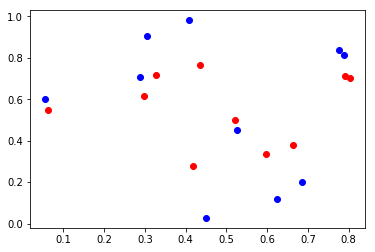

In [127]:
plt.plot(X.detach().numpy(), Y.detach().numpy(), 'o',color='red')
plt.plot(X_origin.numpy(), Y_origin.numpy(), 'o',color='blue')
plt.show()

值得注意的一点是梯度下降法算出来的东西本身是求不了梯度的，从而t统计量依赖的参数估计量如果是梯度下降算出来的（虽然可以解析的表示，
但其实的确是迭代算出来的），则我们不能求出t统计量对X，Y的梯度。

In [128]:
X = torch.ones(_X.shape[0], 2, requires_grad=True)
X[:,1] = torch.tensor(_X, dtype=torch.float32)

In [129]:
X

tensor([[ 1.0000,  0.4077],
        [ 1.0000,  0.0554],
        [ 1.0000,  0.7885],
        [ 1.0000,  0.2873],
        [ 1.0000,  0.4504],
        [ 1.0000,  0.3039],
        [ 1.0000,  0.5264],
        [ 1.0000,  0.6238],
        [ 1.0000,  0.7768],
        [ 1.0000,  0.6862]])

In [130]:
Y = torch.tensor(_Y, dtype=torch.float32, requires_grad=True)

In [131]:
# https://web.stanford.edu/~mrosenfe/soc_meth_proj3/matrix_OLS_NYU_notes.pdf
beta = torch.inverse(torch.transpose(X,0,1) @ X) @ torch.transpose(X,0,1) @ Y #正规方程，怎么感觉好像这计算开销也没记忆中那么大...
beta

tensor([ 0.6659, -0.2071])

In [132]:
e = Y - X @ beta
e

tensor([ 0.3995, -0.0536,  0.3114,  0.1023, -0.5451,  0.3013, -0.1069,
        -0.4178,  0.3303, -0.3215])

In [133]:
n = X.shape[0]
k = X.shape[1]
n,k,n-k

(10, 2, 8)

In [134]:
# https://stats.stackexchange.com/questions/44838/how-are-the-standard-errors-of-coefficients-calculated-in-a-regression

sigma_square = (e @ e)/(n-k)
sigma_square

tensor(0.1320)

In [135]:
var_bar = sigma_square * torch.inverse(torch.transpose(X,0,1) @ X)
var_bar

tensor([[ 0.0765, -0.1290],
        [-0.1290,  0.2630]])

In [136]:
se = torch.sqrt(torch.diag(var_bar))
se

tensor([ 0.2766,  0.5128])

In [137]:
t_test = (beta - 0.0)/se
t_test

tensor([ 2.4073, -0.4038])

In [138]:
print('real p-value\n',sm_res.pvalues)

real p-value
 Intercept    0.042688
X            0.696937
dtype: float64


In [139]:
p_value = torch.distributions.Normal(0,1).cdf(-torch.abs(t_test)) *2
p_value

tensor([ 0.0161,  0.6864])

pytorch现在没提供student t的cdf，看了看jstat的实现也依赖一个迭代的计算，对梯度计算不利（虽然也不是一定不能用），所以这里做个小近似，
调整正态分布的方差来解决。

考虑t分布方差为$\frac{v}{v-2}$

In [140]:
p_value = torch.distributions.Normal(0,np.sqrt((n-k)/(n-k-2))).cdf(-torch.abs(t_test)) *2
p_value

tensor([ 0.0371,  0.7266])

并不是非常准确，下面手动搞个近似

这里用的是《统计计算》的beta分布函数I的连分数展开，t分布的分布函数可以通过一个不是很明显的变换变成beta分布函数的形式。

beta函数的对数

$$
\log \mathrm{B}(a,b) = \log \frac{\Gamma(a)\Gamma(b)}{\Gamma(a+b)} = \log \Gamma(a) + \log \Gamma(b) - \log \Gamma(a+b)
$$

t分布分布函数与beta分布分布函数之关系

$$
T(t \mid n) = \begin{cases}
1 - \frac{1}{2} I_x(\frac{n}{2},\frac{1}{2}) & t>0 \\
\frac{1}{2} I_x(\frac{n}{2},\frac{1}{2}) & t \le 0
\end{cases}
$$

其中
$$
x = \frac{n}{n+t^2}
$$

beta分布分布函数

\begin{align}
I_x(a,b) &= \frac{x^a(1-x)^{b-1}}{\mathrm{B}(a,b)a} \left(
1 + \sum_{k=1}^{\infty}\frac{(b-1)\dots(b-k)}{(a+1)\dots(a+k)}\left( \frac{x}{1-x} \right)^k
\right) \\
&= \exp( a \log(x) +(b-1)\log(1-x)-\log(\mathrm{B}(a,b)) -\log(a) )\left(
1 + \sum_{k=1}^\infty \exp( \sum_{i=1}^k \log(b-i) - \sum_{i=1}^k \log(a+i) + k(\log x - \log(1-x))  )
\right)
\end{align}


In [141]:
def outer(X,Y):
    return X.repeat(Y.shape[0],1).transpose(0,1) * Y

In [142]:
def log_beta(a,b):
    return torch.lgamma(a) + torch.lgamma(b) - torch.lgamma(a+b)


def ibeta(x,a,b,n=5):
    log,exp,cumsum,cumprod,sum = torch.log,torch.exp,torch.cumsum,torch.cumprod,torch.sum
    left = exp(a*log(x) + (b-1)*log(1-x) - log_beta(a,b) - log(a))
    xx = log(x) - log(1.0-x)
    #xx = x/(1-x)
    k = torch.arange(1,n+1,dtype=torch.float32)
    right = 1.0 + sum( (outer(k,xx)).transpose(0,1) * cumprod((b - k)/(a + k), 0) , dim=1)
    return left * right

def student_t_cdf(t, n):
    # 限制 t<0
    x = n/(n+t**2)
    return 0.5 * ibeta(x, torch.tensor(0.5*n), torch.tensor(0.5))

In [143]:
p_value = student_t_cdf(-torch.abs(t_test), n-k) *2
p_value

tensor([ 0.0466,  1.2919])

In [144]:
#X = torch.tensor(np.c_[np.ones(_X.shape[0]),_X], dtype=torch.float32, requires_grad=True)
X = torch.tensor(np.c_[np.ones(_X.shape[0]),_X], dtype=torch.float32)
Y = torch.tensor(_Y, dtype=torch.float32, requires_grad=True)

Y_origin = torch.tensor(_Y, dtype=torch.float32)

In [145]:
optimizer = optim.SGD([Y],lr=0.01)
for epoch in range(100):
    optimizer.zero_grad()
    beta = torch.inverse(torch.transpose(X,0,1) @ X) @ torch.transpose(X,0,1) @ Y
    e = Y - X @ beta
    n = X.shape[0]
    k = X.shape[1]
    sigma_square = (e @ e)/(n-k)
    var_bar = sigma_square * torch.inverse(torch.transpose(X,0,1) @ X)
    se = torch.sqrt(torch.diag(var_bar))
    t_test = (beta - 0.0)/se
    p_value = torch.distributions.Normal(0,np.sqrt((n-k)/(n-k-2))).cdf(-torch.abs(t_test)) *2 #这步是近似计算，因为基于迭代解p值不好求梯度
    
    loss = p_value[1]  + torch.sum((Y-Y_origin)**2)
    loss.backward()
    optimizer.step()

In [146]:
Y

tensor([ 0.9458,  0.8385,  0.5973,  0.7947,  0.1556,  0.9425,  0.4522,
         0.1315,  0.6211,  0.1633])

In [147]:
Y_origin

tensor([ 0.9809,  0.6008,  0.8140,  0.7086,  0.0275,  0.9043,  0.4499,
         0.1189,  0.8353,  0.2022])

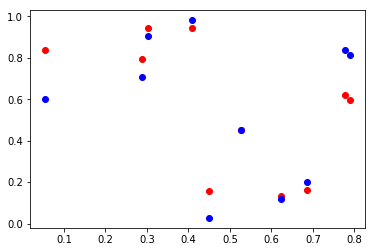

In [148]:
plt.plot(_X, Y.detach().numpy(), 'o',color='red')
plt.plot(_X, Y_origin.numpy(), 'o',color='blue')
plt.show()

In [185]:
def show_change(x_old, y_old, x_new, y_new, line=False):
    dx = x_new - x_old
    dy = y_new - y_old
    
    #plt.show()
    plt.plot(x_new, y_new, 'o', color='blue')
    plt.plot(x_old, y_old, 'o', color='red')
    for i in range(x_old.shape[0]):
        plt.arrow(x_old[i], y_old[i], dx[i], dy[i], head_width=0.02)
    if line:
        a,b = sm.OLS(y_new,np.c_[np.ones(x_new.shape[0]),x_new]).fit().params
        _x = np.array([x_new.min(),x_new.max()])
        _y = a+b*_x
        plt.plot(_x,_y)
    plt.show()
    plt.plot(x_old, y_old, 'o', color='red')
    if line:
        a,b = sm.OLS(y_old,np.c_[np.ones(x_old.shape[0]),x_old]).fit().params
        _x = np.array([x_old.min(),x_old.max()])
        _y = a+b*_x
        plt.plot(_x,_y)
    plt.show()
    plt.plot(x_new, y_new, 'o', color='blue')
    if line:
        a,b = sm.OLS(y_new,np.c_[np.ones(x_new.shape[0]),x_new]).fit().params
        _x = np.array([x_new.min(),x_new.max()])
        _y = a+b*_x
        plt.plot(_x,_y)
    plt.show()

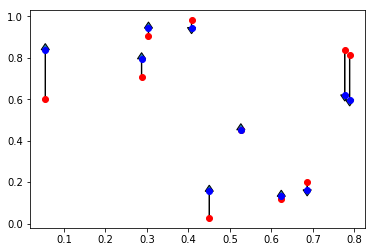

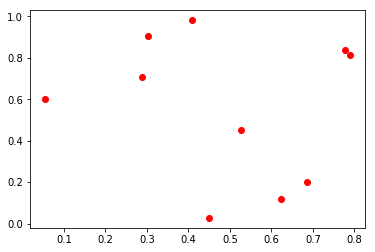

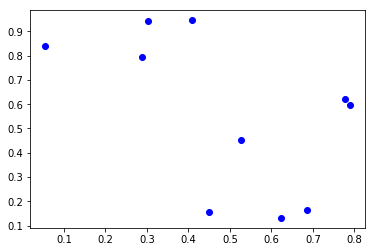

In [150]:
show_change(_X,_Y,_X,Y.detach().numpy())
plt.show()

In [151]:
df_new = df.copy()
df_new['Y'] = Y.detach().numpy()

In [152]:
res_new_df = smf.ols('Y ~ X',data=df_new).fit()
res_new_df.summary()

D:\anaconda\lib\site-packages\scipy\stats\stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     3.129
Date:                Thu, 10 May 2018   Prob (F-statistic):              0.115
Time:                        13:03:55   Log-Likelihood:               -0.76337
No. Observations:                  10   AIC:                             5.527
Df Residuals:                       8   BIC:                             6.132
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9219      0.222      4.148      0.003       0.409       1.434
X             -0.7290      0.412     -1.769      0.115      -1.679       0.221
==============================================================================
Omnibus:                        1.936   Durbin-Watson:                   2.618
Prob(Omnibus):                  0.380   Jarque-Bera (JB):                0.928
Skew:                          -0.323   Prob(JB):                        0.629
Kurtosis:                       1.655   Cond. No.                         5.58
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [153]:
n = _X.shape[0]
k = 2

for i in range(n):
    X = torch.tensor(np.c_[np.ones(_X.shape[0]),_X], dtype=torch.float32)
    #Y = torch.tensor(_Y, dtype=torch.float32)
    y = torch.tensor(_Y[i], dtype=torch.float32, requires_grad=True)
    #Y[i] = y
    
    optimizer = optim.SGD([y],lr=0.01)
    for epoch in range(100):
        optimizer.zero_grad()
        
        Y = torch.tensor(_Y, dtype=torch.float32) #把Y放外面会出又要求梯度又求过一次梯度那个错误
        Y[i] = y
        
        beta = torch.inverse(torch.transpose(X,0,1) @ X) @ torch.transpose(X,0,1) @ Y
        e = Y - X @ beta
        sigma_square = (e @ e)/(n-k)
        var_bar = sigma_square * torch.inverse(torch.transpose(X,0,1) @ X)
        se = torch.sqrt(torch.diag(var_bar))
        t_test = (beta - 0.0)/se
        p_value = torch.distributions.Normal(0,np.sqrt((n-k)/(n-k-2))).cdf(-torch.abs(t_test)) *2 #这步是近似计算，因为基于迭代解p值不好求梯度

        loss = p_value[1] # + torch.sum((Y-Y_origin)**2)
        loss.backward()
        optimizer.step()
    
    df_new = df.copy()
    df_new['Y'] = Y.detach().numpy()
    res_new_df = smf.ols('Y ~ X',data=df_new).fit()
    res_new_df.summary()
    print(i,res_new_df.pvalues)

D:\anaconda\lib\site-packages\scipy\stats\stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


0 Intercept    0.044796
X            0.686743
dtype: float64
1 Intercept    0.008878
X            0.186715
dtype: float64
2 Intercept    0.017120
X            0.263471
dtype: float64
3 Intercept    0.032179
X            0.534383
dtype: float64
4 Intercept    0.022565
X            0.636182
dtype: float64
5 Intercept    0.040977
X            0.588773
dtype: float64
6 Intercept    0.044731
X            0.693443
dtype: float64
7 Intercept    0.056151
X            0.655540
dtype: float64
8 Intercept    0.017125
X            0.272989
dtype: float64
9 Intercept    0.056930
X            0.581272
dtype: float64


In [154]:
def optim_Y(optim_i, _X, _Y, target_X_i):
    # 这里假设_X是完整的设计矩阵，包括全1列.optim_i是要被优化的i，target_X_i是用来优化p-value的列
    n = _X.shape[0]
    k = _X.shape[1]
    
    #X = torch.tensor(np.c_[np.ones(_X.shape[0]),_X], dtype=torch.float32)
    X = torch.tensor(_X, dtype=torch.float32)
    #Y = torch.tensor(_Y, dtype=torch.float32)
    y = torch.tensor(_Y[optim_i], dtype=torch.float32, requires_grad=True)
    #Y[i] = y
    
    optimizer = optim.SGD([y],lr=0.01)
    for epoch in range(100):
        optimizer.zero_grad()
        
        Y = torch.tensor(_Y, dtype=torch.float32) #把Y放外面会出又要求梯度又求过一次梯度那个错误
        Y[optim_i] = y
        
        beta = torch.inverse(torch.transpose(X,0,1) @ X) @ torch.transpose(X,0,1) @ Y
        e = Y - X @ beta
        sigma_square = (e @ e)/(n-k)
        var_bar = sigma_square * torch.inverse(torch.transpose(X,0,1) @ X)
        se = torch.sqrt(torch.diag(var_bar))
        t_test = (beta - 0.0)/se
        p_value = torch.distributions.Normal(0,np.sqrt((n-k)/(n-k-2))).cdf(-torch.abs(t_test)) *2 #这步是近似计算，因为基于迭代解p值不好求梯度

        loss = p_value[target_X_i] # + torch.sum((Y-Y_origin)**2)
        loss.backward()
        optimizer.step()
    
    return y.item(),loss.item()
    
def select_Y(_X,_Y,target_X_i,exclude=None):
    n = _X.shape[0]
    k = _X.shape[1]
    
    if exclude is None:
        exclude = set()
    else:
        exclude = set(exclude)
    
    res = []
    for i in set(range(n)) - exclude:
        y,loss = optim_Y(i, _X, _Y, target_X_i)
        __Y = _Y.copy()
        __Y[i] = y
        res.append((i, y, sm.OLS(__Y,_X).fit().pvalues[target_X_i],loss)) # 位置id，对应的新取值,对应的精确值，对应的拟合p值
    
    #return min(res,key=lambda tup:tup[2])
    return res

In [155]:
select_Y(np.c_[np.ones(_X.shape[0]),_X],_Y,1)

[(0, 1.078026294708252, 0.6866632688134766, 0.7171699404716492),
 (1, 1.2860039472579956, 0.18545294589673883, 0.21107953786849976),
 (2, 0.17122475802898407, 0.2619249437108776, 0.2976055145263672),
 (3, 1.0969321727752686, 0.5334488099644799, 0.5739478468894958),
 (4, 0.2659122049808502, 0.6356055245391424, 0.6702769994735718),
 (5, 1.2202457189559937, 0.5881093283047427, 0.625769853591919),
 (6, 0.39306116104125977, 0.6934151428690425, 0.7233450412750244),
 (7, -0.076571524143219, 0.6552482991114514, 0.6882956027984619),
 (8, 0.19897446036338806, 0.271411798162778, 0.30801546573638916),
 (9, -0.12443533539772034, 0.5805745896177972, 0.6186740398406982)]

In [156]:
def greedy_make_up(limit,_X,_Y,target_X_i):
    selected = []
    _Y = _Y.copy()
    trace = [sm.OLS(_Y,_X).fit().pvalues[target_X_i]]
    for i in range(limit):
        i,y,pvalue,pvaluehat = min(select_Y(_X, _Y, target_X_i, exclude=selected),key=lambda term:term[2])
        selected.append(i)
        trace.append(pvalue)
        _Y[i] = y
    return _Y,trace,selected

In [158]:
greedy_make_up(3,np.c_[np.ones(_X.shape[0]),_X],_Y,1)

(array([0.98093886, 1.28600395, 0.46733743, 0.70864515, 0.02753468,
        0.90426722, 0.44990485, 0.11892465, 0.60710645, 0.20224823]),
 [0.6969367513739502,
  0.18545294589673883,
  0.0812813925153782,
  0.03626248251035322],
 [1, 2, 8])

In [159]:
Y_makeup, trace,selected = greedy_make_up(2,np.c_[np.ones(_X.shape[0]),_X],_Y,1)

In [160]:
Y_makeup - _Y

array([ 0.        ,  0.68518786, -0.34663109,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

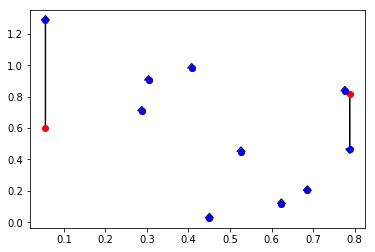

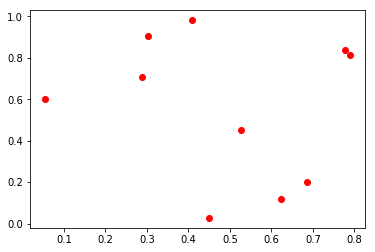

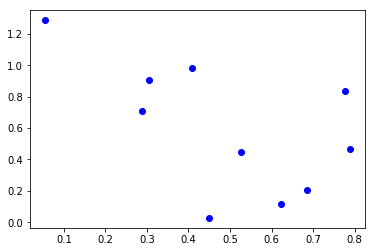

In [161]:
show_change(_X,_Y,_X,Y_makeup)

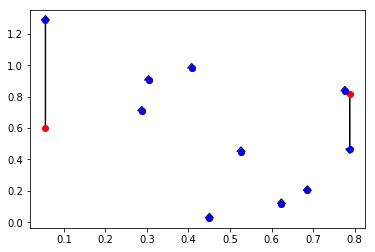

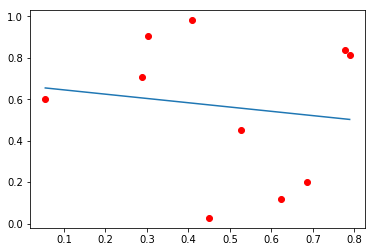

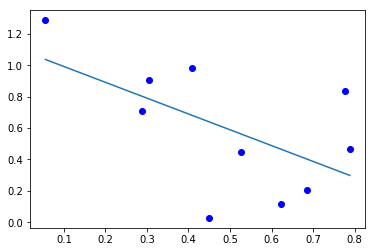

In [182]:
show_change(_X,_Y,_X,Y_makeup,line=True)

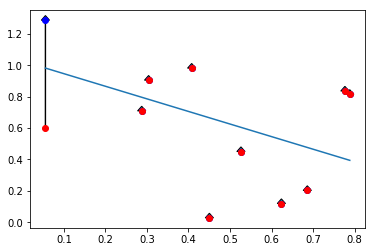

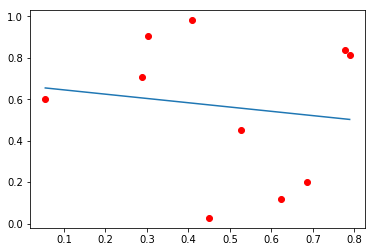

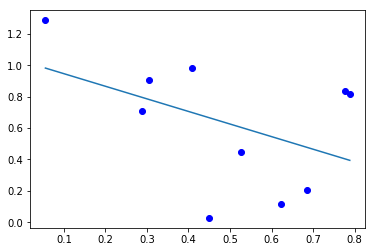

In [186]:
Y_makeup, trace,selected = greedy_make_up(1,np.c_[np.ones(_X.shape[0]),_X],_Y,1)
show_change(_X,_Y,_X,Y_makeup,line=True)

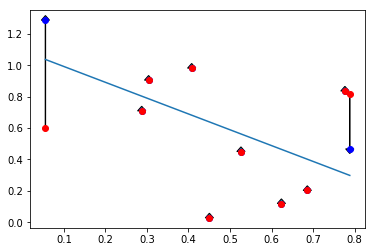

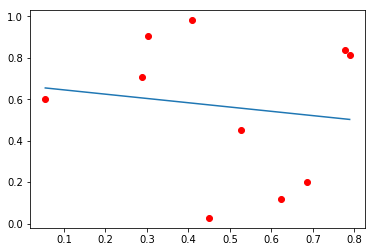

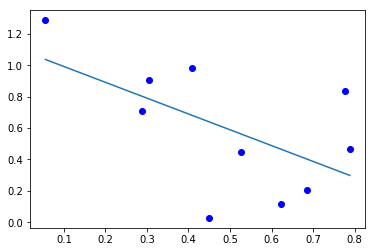

In [187]:
Y_makeup, trace,selected = greedy_make_up(2,np.c_[np.ones(_X.shape[0]),_X],_Y,1)
show_change(_X,_Y,_X,Y_makeup,line=True)

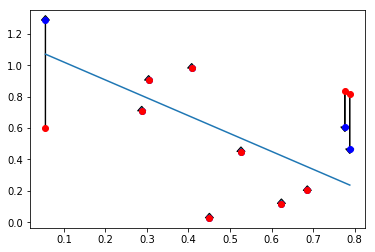

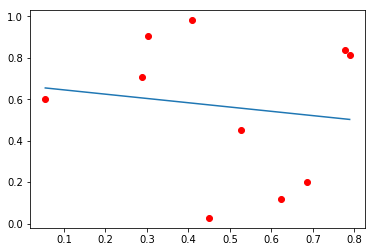

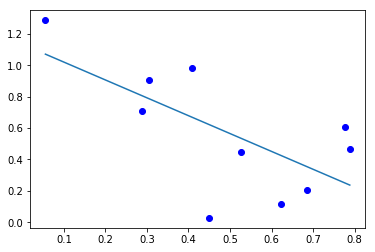

In [188]:
Y_makeup, trace,selected = greedy_make_up(3,np.c_[np.ones(_X.shape[0]),_X],_Y,1)
show_change(_X,_Y,_X,Y_makeup,line=True)

## 新插入的数据-一个恰当的位置

插入一个新数据等价于随便插个点再对那个点重复上述过程，不过对此二维设定来说，使用格点查看各个点插入带来的p值下降效果的二维图是更令人感兴趣的。



In [162]:
__X = np.linspace(_X.min(),_X.max(),100)
__Y = np.linspace(_Y.min(),_Y.max(),100)

In [163]:
x_range = _X.max()-_X.min()
y_range = _Y.max()-_Y.min()

In [164]:
__X = np.linspace(_X.min()-x_range,_X.max()+x_range,100)
__Y = np.linspace(_Y.min()-x_range,_Y.max()+x_range,100)

In [165]:
Xv, Yv = np.meshgrid(__X,__Y)

In [166]:
XYv = np.c_[Xv.ravel(),Yv.ravel()]

In [167]:
pv = np.empty(XYv.shape[0])

In [168]:
for i,XY in enumerate(XYv):
    #X_added = np.r_[_X,np.ones(shape=(1,2))]
    X_added = np.c_[np.ones(n+1),np.r_[_X,XY[0]]]
    Y_added = np.r_[_Y,XY[1]]
    pv[i] = sm.OLS(Y_added,X_added).fit().pvalues[1]

In [169]:
pv.reshape(Xv.shape)

array([[0.05542581, 0.05765539, 0.0600349 , ..., 0.02656957, 0.02533454,
        0.02419479],
       [0.0585129 , 0.06081351, 0.06326702, ..., 0.02796176, 0.02669626,
        0.02552739],
       [0.0618194 , 0.06419369, 0.06672387, ..., 0.02945858, 0.02816166,
        0.02696273],
       ...,
       [0.02928017, 0.03016032, 0.03110191, ..., 0.11051123, 0.10616335,
        0.10208942],
       [0.02737315, 0.02822705, 0.0291412 , ..., 0.1050379 , 0.10080188,
        0.09683614],
       [0.02561803, 0.02644639, 0.02733381, ..., 0.09990554, 0.09577861,
        0.09191828]])

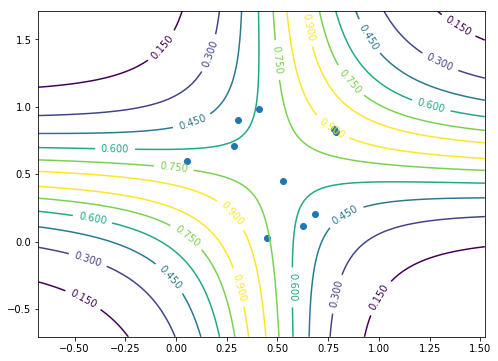

In [170]:
plt.figure(figsize=(8,6))
CS = plt.contour(Xv,Yv,pv.reshape(Xv.shape))
plt.clabel(CS)
plt.scatter(_X,_Y)
plt.show()

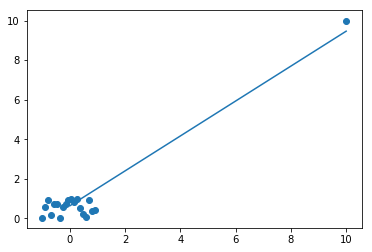

In [190]:
Xq = np.linspace(-1,1,20)
Yq = np.random.random(20)
Xq[-1] = 10
Yq[-1] = 10

a,b = sm.OLS(Yq,np.c_[np.ones(20),Xq]).fit().params
plt.scatter(Xq,Yq)
plt.plot(np.array([0,10]),np.array([a+0*b,a+10*b]))
plt.show()